In [11]:
import sys
sys.path.append('../external/stylegan3')

from tqdm.auto import tqdm

import torch
import dnnlib, legacy

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sys.path.append('../')
from sb.nn.cifar import CifarCls

device = torch.device('cuda:3')
network_pkl = "../reward_ckpt/stylegan2-cifar10-32x32.pkl"

In [3]:
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) 

/home/jovyan/workspace/energy-sb/notebooks/../external/stylegan3/torch_utils/ops/conv2d_gradfix.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [6]:
cls_ = CifarCls().to(device)
cls_.load_state_dict(torch.load('../reward_ckpt/cifar_cls.pt'))
None

In [4]:
z = torch.randn(512, G.z_dim, device=device)
c = torch.zeros(512, G.c_dim, device=device)

with torch.no_grad():
    y = G(z, c)
    y = (y + 1) / 2

Setting up PyTorch plugin "bias_act_plugin"... 

/opt/saturncloud/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/opt/saturncloud/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


In [12]:
dogs = torch.zeros(0, 512, device=device)
pbar = tqdm(total=512)

while dogs.size(0) < 512:
    with torch.no_grad():
        z = torch.randn(512, G.z_dim, device=device)
        c = torch.zeros(512, G.c_dim, device=device)

        y = (G(z, c) + 1) / 2
        proba = cls_(y).softmax(dim=1)[:, 5]
        dogs_latents = z[proba > 0.9]
        dogs = torch.cat([dogs, dogs_latents], dim=0)
        num_added_samples = torch.sum(proba > 0.9).item()
        pbar.update(num_added_samples)

dogs = dogs[:512]

516it [00:33, 21.06it/s]                         

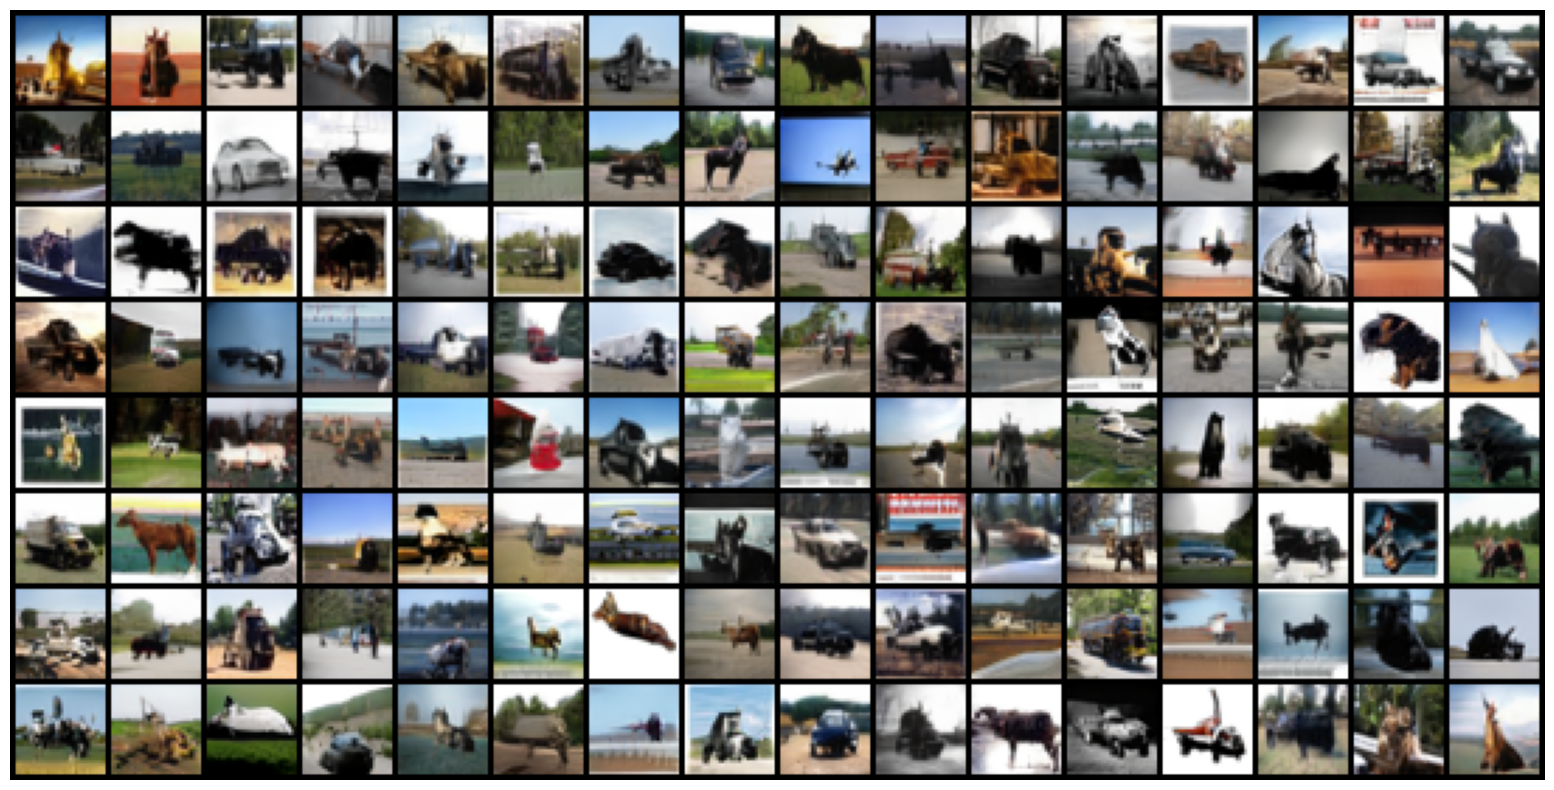

In [4]:
plt.figure(figsize=(20, 10))
plt.imshow(make_grid(y.cpu(), nrow=16).permute(1, 2, 0).clip(0, 1))
plt.axis('off')
plt.show()

In [9]:
cls_ = CifarCls().to(device)
cls_.load_state_dict(torch.load('../reward_ckpt/cifar_cls.pt'))
with torch.no_grad():
    proba = cls_(y).softmax(dim=1)[:, [5]]

In [20]:
with torch.no_grad():
    z = torch.randn(512, G.z_dim, device=device)
    c = torch.zeros(512, G.c_dim, device=device)

    y = (G(z, c) + 1) / 2
    proba = cls_(y).softmax(dim=1)
    classes = proba.argmax(dim=1)

/opt/saturncloud/envs/stylegan3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/saturncloud/envs/stylegan3/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/opt/saturncloud/envs/stylegan3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


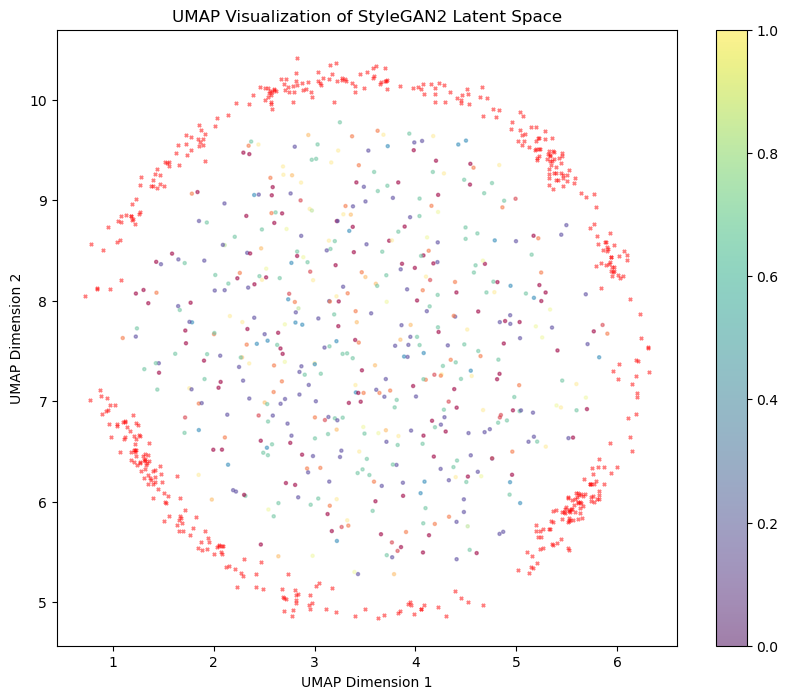

In [27]:
import umap.umap_ as umap
import numpy as np

import matplotlib.pyplot as plt

# Convert latent space z to CPU and numpy
z_np = z.cpu().numpy()

# Initialize UMAP
reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
z_embedded = reducer.fit_transform(z_np)
z_dog = reducer.transform(dogs.cpu().numpy())

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], s=5, alpha=0.5, c=classes.cpu().numpy(), cmap='Spectral', marker='o')
plt.scatter(*z_dog.T, s=5, alpha=0.5, c='r', cmap='Spectral', marker='x')
plt.title('UMAP Visualization of StyleGAN2 Latent Space')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar()
plt.show()